In [50]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
eventname = ''
eventname = 'GW170817' 
detector = 'H1'

# want plots?
make_plots = 1

virgo_pres = 0
plottype = "png"


# Define signal properties for the simulation of the signal later 
sampling_rate = 4096 # Hz
fs = sampling_rate

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lal

import lalsimulation
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from scipy import signal
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# LIGO-specific readligo.py 
import readligo as rl

#for curve fit
from scipy.optimize import curve_fit

plottype = "png"

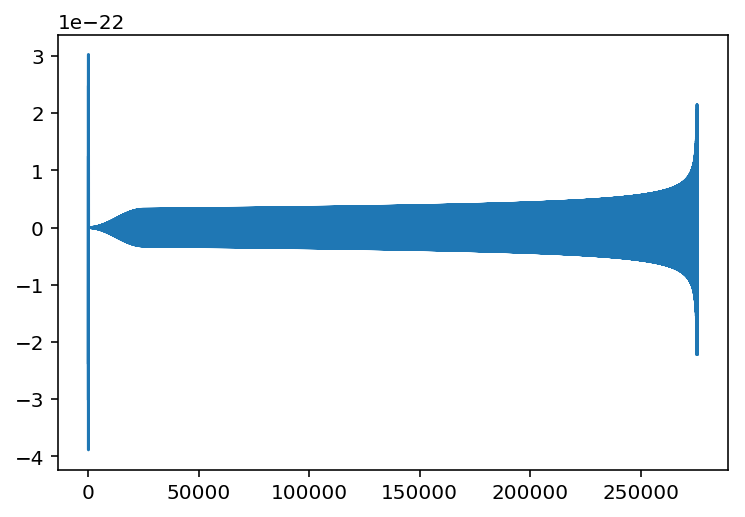

In [52]:
#load the simulated event
hoftprime = np.loadtxt("{0}simulationSR{1}Event{2}.txt".format(detector,sampling_rate,eventname))
#cut the first 20 values 
hoft = hoftprime[20:]
plt.plot(hoft)
n = len(hoft)


In [53]:
# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

In [54]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']  
if(virgo_pres):
    fn_V1 = event['fn_V1']

fn_template = event['fn_template']  # File name for template waveform
#fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW170817
{u'fband': [43.0, 300.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'GW170817', u'utcevent': u'2017-08-17T12:41:04.43', u'fn_H1': u'H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5', u'a1': 0, u'fn_V1': u'V-V1_LOSC_CLN_4_V1-1187007040-2048.hdf5', u'fn_L1': u'L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5', u'm1': 1.5, u'f_min': 10.0, u'fn_template': u'GW150914_4_template.hdf5', u'm2': 1.25, u'tevent': 1187008882.43, u'a2': 0}


In [55]:
#read in data
#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
    if(virgo_pres):
        strain_V1, time_V1, chan_dict_V1 = rl.loaddata(fn_V1, 'V1') 
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()

In [56]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# number of sample for the fast fourier transform:
NFFT = 4*fs
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)
if(virgo_pres):
    Pxx_V1, freqs = mlab.psd(strain_V1, Fs = fs, NFFT = NFFT)

Text(0.5,1,u'Advanced LIGO strain data near GW170817')

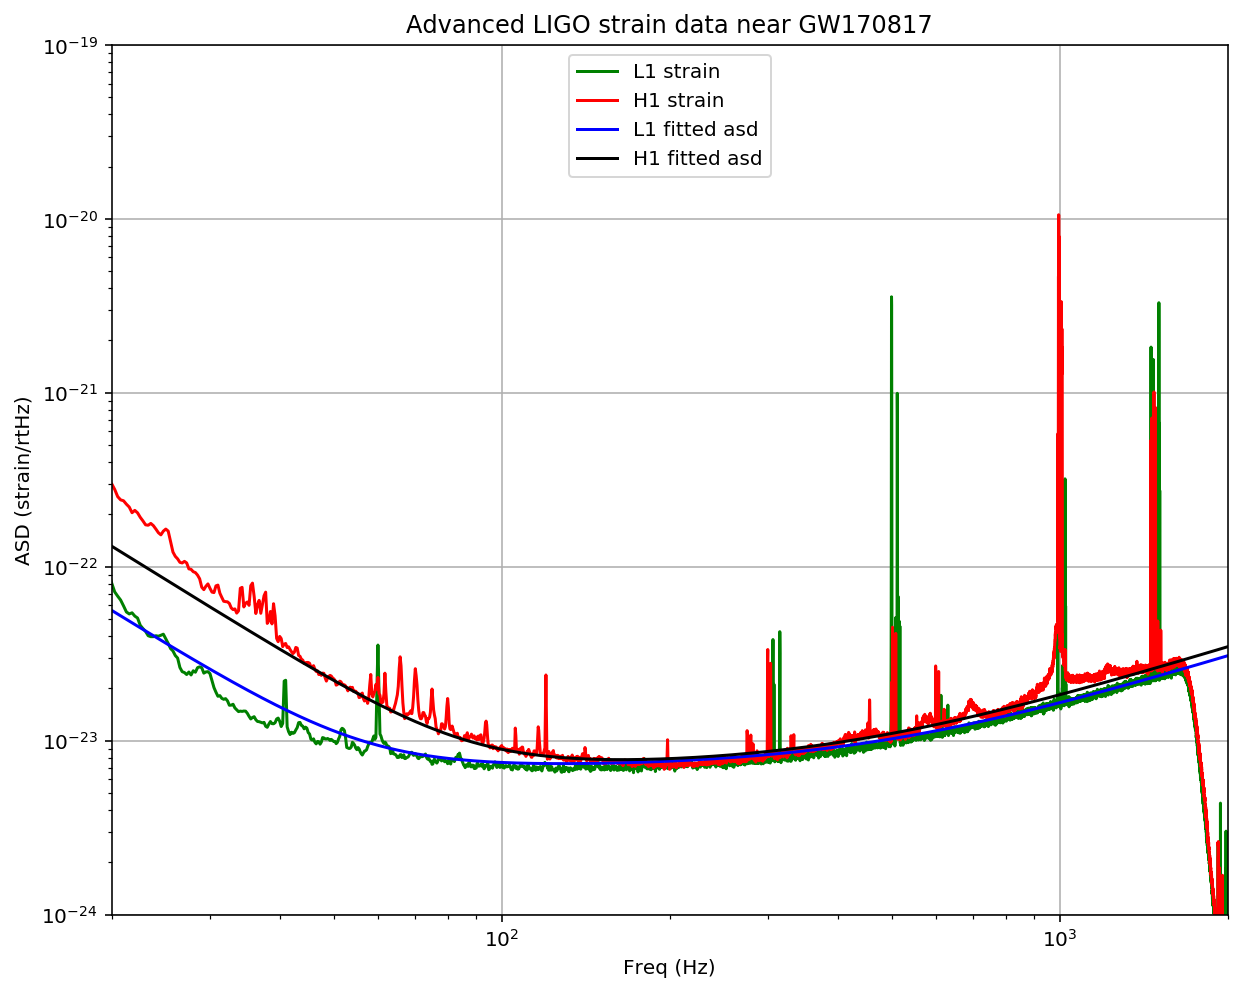

In [57]:
#handmade PSD from tutorial
freqs_2 = np.linspace(0,2048,n)

#Fits for GW150914
#Pxx_L1_fit = (1e-22*(24./(0.1+freqs_2))**2)**2+0.7e-23**2+((freqs_2/2000.)*3.4e-23)**2
#Pxx_H1_fit = (1e-22*(17./(0.1+freqs_2))**2)**2+0.7e-23**2+((freqs_2/2000.)*3.4e-23)**2

#Fits for GW170817
Pxx_L1_fit = (1e-22*(15./(0.1+freqs_2))**2)**2+0.7e-23**2+((freqs_2/2000.)*3.e-23)**2
Pxx_H1_fit = (1e-22*(23./(0.1+freqs_2))**2)**2+0.7e-23**2+((freqs_2/2000.)*3.4e-23)**2
Pxx_V1_fit = (1e-22*(35./(0.1+freqs_2))**2)**2+0.7e-23**2+((freqs_2/2000.)*15e-23)**2

# plot the ASDs, with the template overlaid:
f_min = 20.
f_max = 2000. 
plt.figure(figsize=(10,8))
plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
if(virgo_pres):
    plt.loglog(freqs, np.sqrt(Pxx_V1),'brown',label='V1 strain')

plt.loglog(freqs_2,np.sqrt(Pxx_L1_fit),'b', label='L1 fitted asd')
plt.loglog(freqs_2,np.sqrt(Pxx_H1_fit),'black', label='H1 fitted asd')
if(virgo_pres):
    plt.loglog(freqs_2,np.sqrt(Pxx_V1_fit),'yellow', label='V1 fitted asd')

#plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
plt.axis([f_min, f_max, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near '+eventname)
#plt.savefig(eventname+'_ASDs.'+plottype)


In [73]:
datafreq = np.fft.fftfreq(n)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(hoft.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(hoft.size)          # Blackman window OK if Tukey is not available

template_fft = interp1d(np.fft.fft(hoft*dwindow)/fs)

plt.loglog(template_fft)

TypeError: __init__() takes at least 3 arguments (2 given)

In [59]:
if(detector=='L1'):
    power_vec = Pxx_L1_fit
if(detector=='H1'):
    power_vec = Pxx_H1_fit
if(detector=='V1'):
    power_vec = Pxx_V1_fit

10.3705377438
0.0148618493859


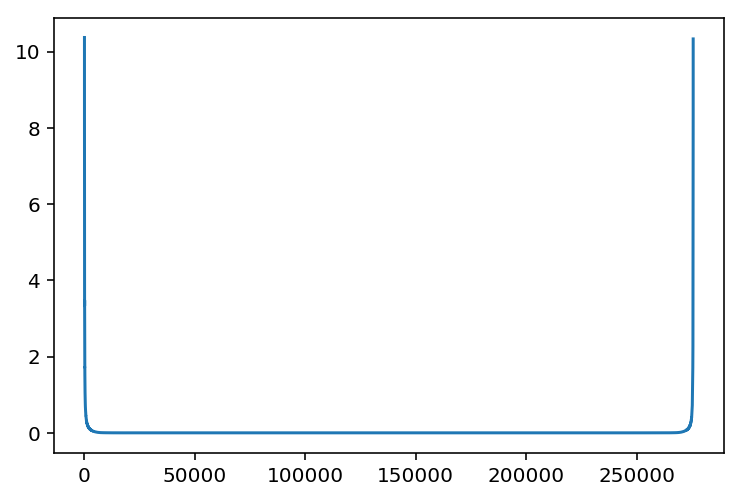

In [66]:
zoft = 4.*np.fft.ifft(template_fft*template_fft.conjugate()/power_vec)*fs

sigma = np.sqrt(4.0 * np.sum(template_fft*template_fft.conjugate()/power_vec).real*df)

SNR = (abs(zoft)/sigma)

plt.plot(SNR)
print(SNR.max())

In [61]:
z_0 = 4.0 * df * np.sum(np.abs(template_fft)**2/power_vec)

sigmasq = 4.0 * np.sum(template_fft*template_fft.conjugate()/power_vec).real*df

SNR = z_0/np.sqrt(sigmasq)

print SNR

10.3705377438


In [62]:
print np.sqrt(4.0 * df * np.sum(np.abs(template_fft)**2/power_vec))

10.3705377438


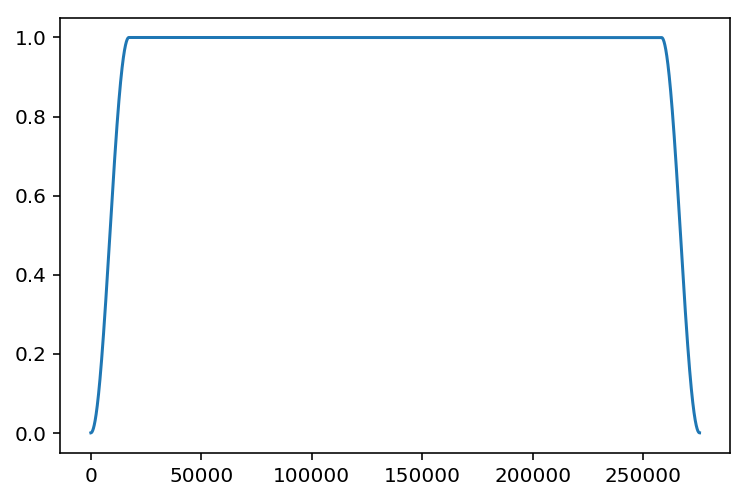

In [63]:
plt.plot(np.linspace(1,1,n)*dwindow);

In [64]:
# number of sample for the fast fourier transform:
NFFT = 4*fs
Pxx, freqs = mlab.psd(hoft, Fs = fs, NFFT = NFFT)

In [65]:
N = int((f_max - f_min) / df)
psd = lal.CreateREAL8FrequencySeries('psd', lal.LIGOTimeGPS(0,0),f_min,df,lal.HertzUnit,N)

lalsimulation.MeasureSNR(x, psd, f_min,f_max)

NameError: name 'x' is not defined